# Archetype Analysis

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
from sklearn.datasets import load_iris

wine = load_iris()

X = wine.data
target = wine.target

In [84]:
from archetypes.sklearn import AA

method_kwargs = {
    "max_iter_optimizer": 10,
}

model = AA(
    n_archetypes=3,
    max_iter=1_000,
    tol=1e-4,
    random_state=10,
    method="pgd",
    method_kwargs=method_kwargs,
)

model.fit(X)

model.archetypes_

array([[4.96042637, 2.19787607, 3.89574935, 1.27702458],
       [7.56594327, 3.23047798, 6.62511408, 2.32342248],
       [4.90279862, 3.51535124, 1.10614432, 0.16288546]])

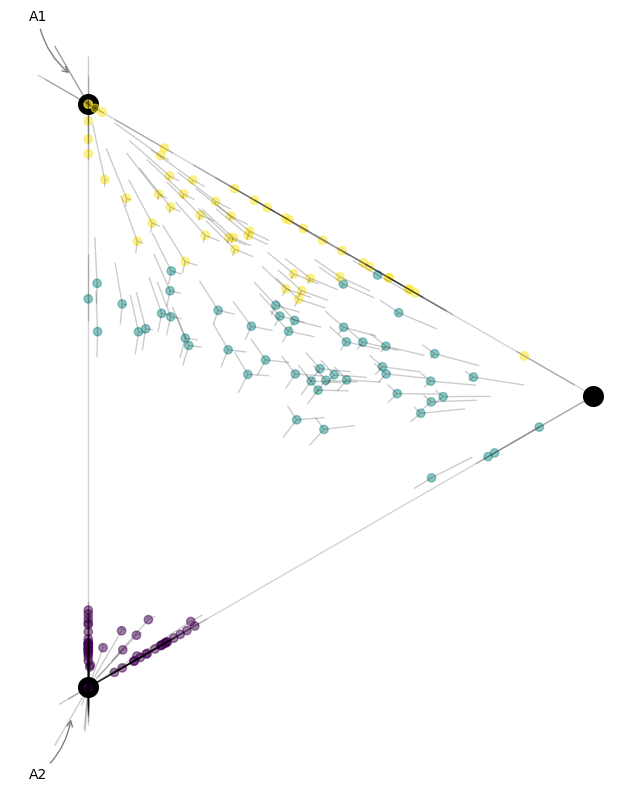

In [85]:
import matplotlib.pyplot as plt
from archetypes.visualization import simplex

plt.figure(figsize=(10, 10))
simplex(model.similarity_degree_, c=target, alpha=0.5, show_circle=False, show_direction=True)

plt.show()